In [1]:
import os
import warnings
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gamma, norm, expon
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

In [3]:
data.head(20)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166,1056.25,113,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103,1173.75,92,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131,1140.00,114,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172,1092.00,122,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131,1205.00,116,1490.00,1110.00,11.150,59.575001,0.788794
5,1.2,1197.00,38,4.741012,750.25,89,1336.50,96,1393.00,949.25,11.175,59.175000,0.784772
6,1.2,1185.00,31,3.624399,689.50,62,1461.75,77,1332.75,732.50,11.325,56.775000,0.760312
7,1.0,1136.25,31,3.326677,672.00,62,1453.25,76,1332.75,729.50,10.675,60.000000,0.770238
8,0.9,1094.00,24,2.339416,608.50,45,1579.00,60,1276.00,619.50,10.650,59.674999,0.764819
9,0.7,1066.00,8,1.133431,512.00,16,1918.00,28,1182.00,421.75,11.000,56.175000,0.736560


In [4]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [5]:
# initialising min max scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

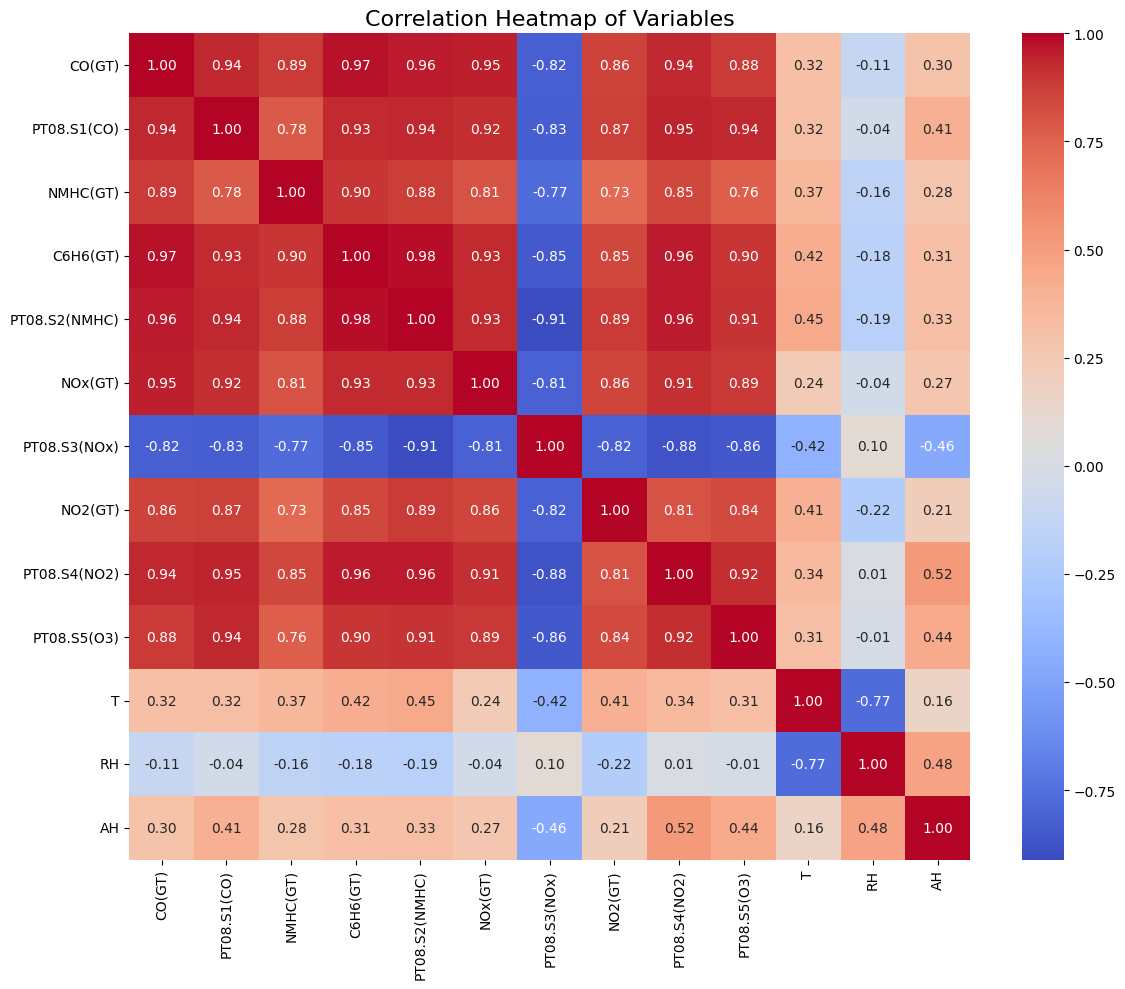

In [6]:
# Calculate the correlation matrix
correlation_matrix = scaled_data.corr()#data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_after_transformation.png")
plt.show()


In [7]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variables
# data = data[[target_variable] + predictor_variables].dropna()
scaled_data = scaled_data[[target_variable] + predictor_variables].dropna()

# Prepare predictors and target
X = scaled_data[predictor_variables]
y = scaled_data[target_variable]

# Ensure the target variable contains only positive values
if (y <= 0).any():
    print("Target variable contains non-positive values. Adjusting...")
    y += 0.001  # Add a small constant to ensure positivity

# Define the Bayesian Gamma Regression Model
with pm.Model() as gamma_model:
    # Priors for the coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Linear predictor
    mu = pm.math.exp(pm.math.dot(X.values, beta) + intercept)
    alpha = pm.HalfCauchy("alpha", beta=2)  # Shape parameter
    
    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y.values)
    
    # Initialize model with a custom start point
    initial_point = gamma_model.initial_point()
    initial_point["alpha"] = 1.0  # Positive initial value for alpha
    initial_point["beta"] = np.zeros(X.shape[1])  # Start with all coefficients at 0
    initial_point["intercept"] = np.log(np.mean(y))  # Approximate initial intercept
    
    # Sampling
    idata = pm.sample(1000, tune=500, init="adapt_diag", start=initial_point)#, return_inferencedata=True

# Summarize the posterior
summary = idata.posterior#.to_dataframe()
# summary.head()


Target variable contains non-positive values. Adjusting...


Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, alpha]


Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 60 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


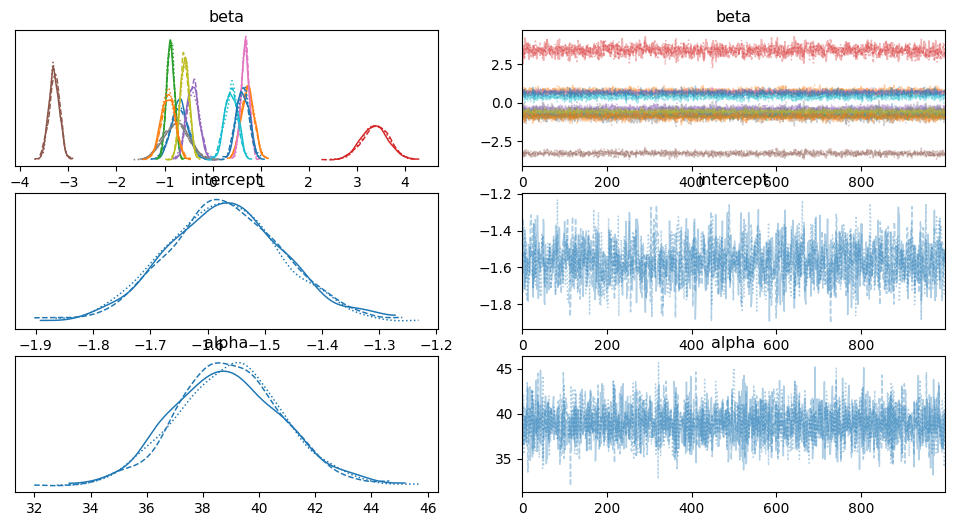

In [8]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(summary)
az.plot_trace(summary, figsize=(20, 10), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

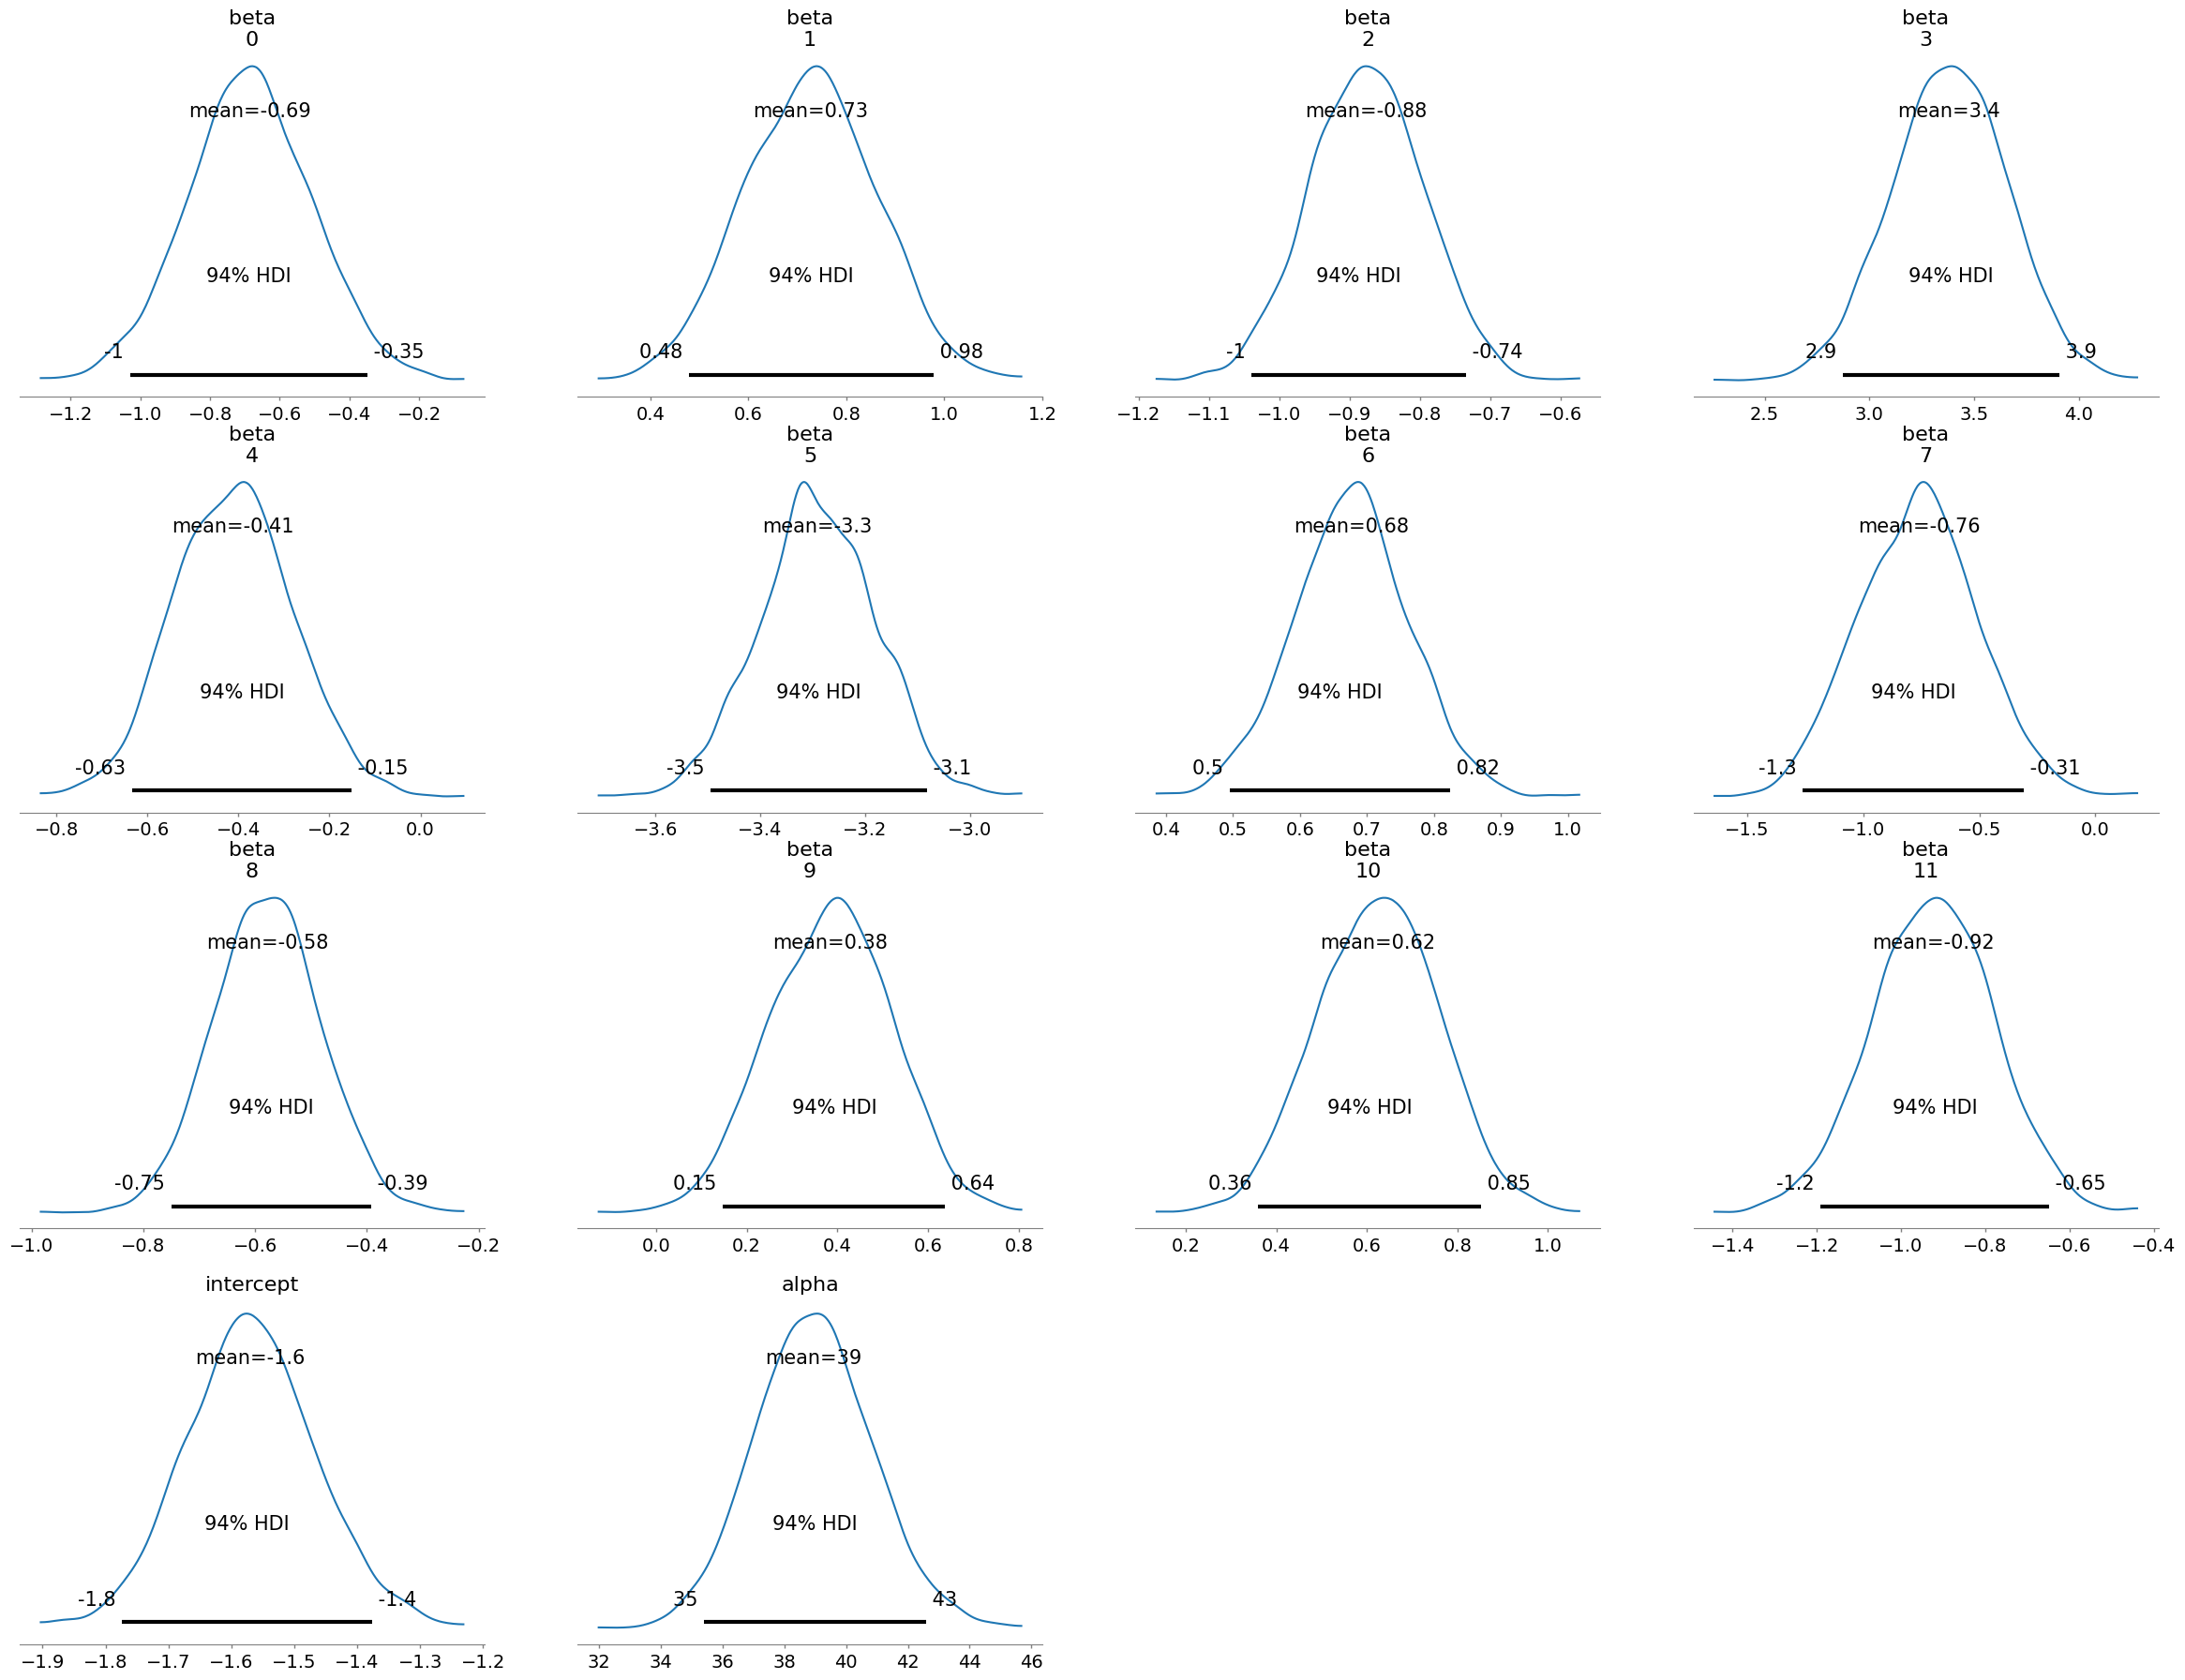

In [9]:
az.plot_posterior(summary)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

# Display the posterior summary
# posterior_summary.to_csv('/mnt/data/posterior_summary.csv')
# posterior_summary

Sampling: [target]


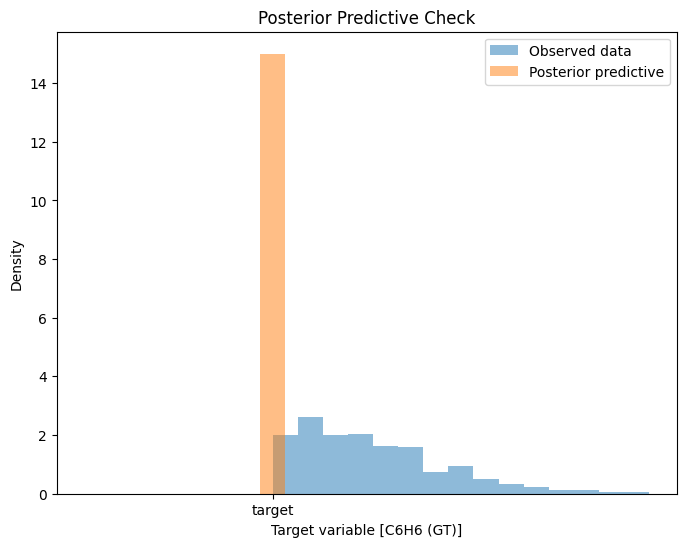

In [10]:
# trace = pm.sample(1000, tune=500, init="adapt_diag", start=initial_point)
posterior_predictive = pm.sample_posterior_predictive(idata, model=gamma_model)
# print(type(posterior_predictive))
# print(posterior_predictive)

# Visualize the posterior predictive checks
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(y, bins=15, density=True, alpha=0.5, label="Observed data")
ax.hist(posterior_predictive["posterior_predictive"], bins=15, density=True, alpha=0.5, label="Posterior predictive")
ax.set_xlabel("Target variable [C6H6 (GT)]")
ax.set_ylabel("Density")
ax.legend()
plt.title("Posterior Predictive Check")
plt.show()

In [11]:
summary_df = summary.to_dataframe()
summary_df.head(20)

beta  intercept      alpha
chain draw beta_dim_0                                
0     0    0          -0.542399  -1.553182  39.966829
           1           0.806670  -1.553182  39.966829
           2          -0.833618  -1.553182  39.966829
           3           3.556217  -1.553182  39.966829
           4          -0.460506  -1.553182  39.966829
           5          -3.278156  -1.553182  39.966829
           6           0.651645  -1.553182  39.966829
           7          -1.161007  -1.553182  39.966829
           8          -0.567046  -1.553182  39.966829
           9           0.329687  -1.553182  39.966829
           10          0.582348  -1.553182  39.966829
           11         -0.789160  -1.553182  39.966829
      1    0          -0.665356  -1.555849  39.770733
           1           0.823208  -1.555849  39.770733
           2          -0.863925  -1.555849  39.770733
           3           3.515547  -1.555849  39.770733
           4          -0.337435  -1.555849  39.770733
           5          -3.286410  -1.555849  39.770733
           6           0.734459  -1.555849  39.770733
           7          -1.296412  -1.555849  39.770733

In [12]:
# summary_df.to_excel("first_model.xlsx")

In [13]:
summary_df["beta"].max()

4.2807795404852715

Student t-model

In [14]:
with pm.Model() as student_t_model:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    nu = pm.Exponential("nu", 1.0)  # Degrees of freedom
    mu = pm.math.dot(X.values, beta) + intercept
    target = pm.StudentT("target", nu=nu, mu=mu, sigma=1.0, observed=y.values)
    trace_student_t = pm.sample(1000, tune=500)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, nu]


Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [15]:
student_t_summary = trace_student_t.posterior

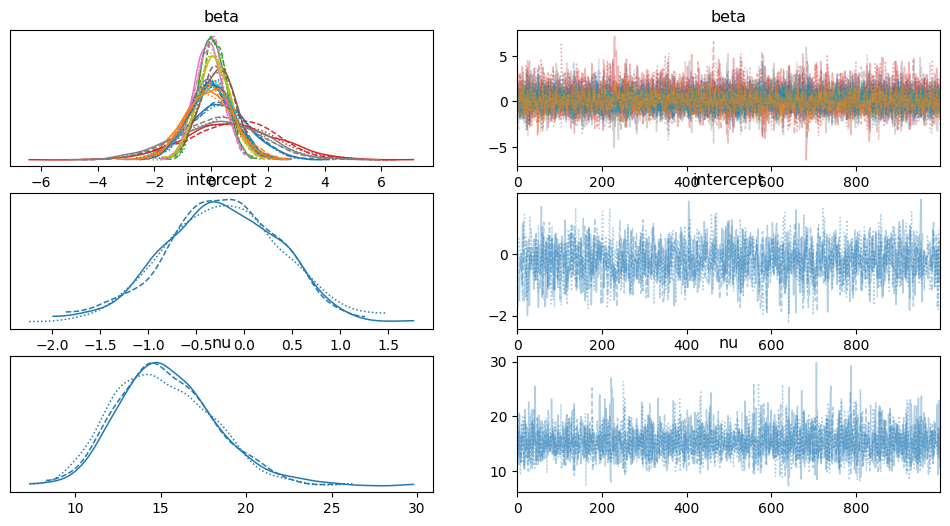

In [ ]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(student_t_summary)
az.plot_trace(student_t_summary, figsize=(20, 10), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

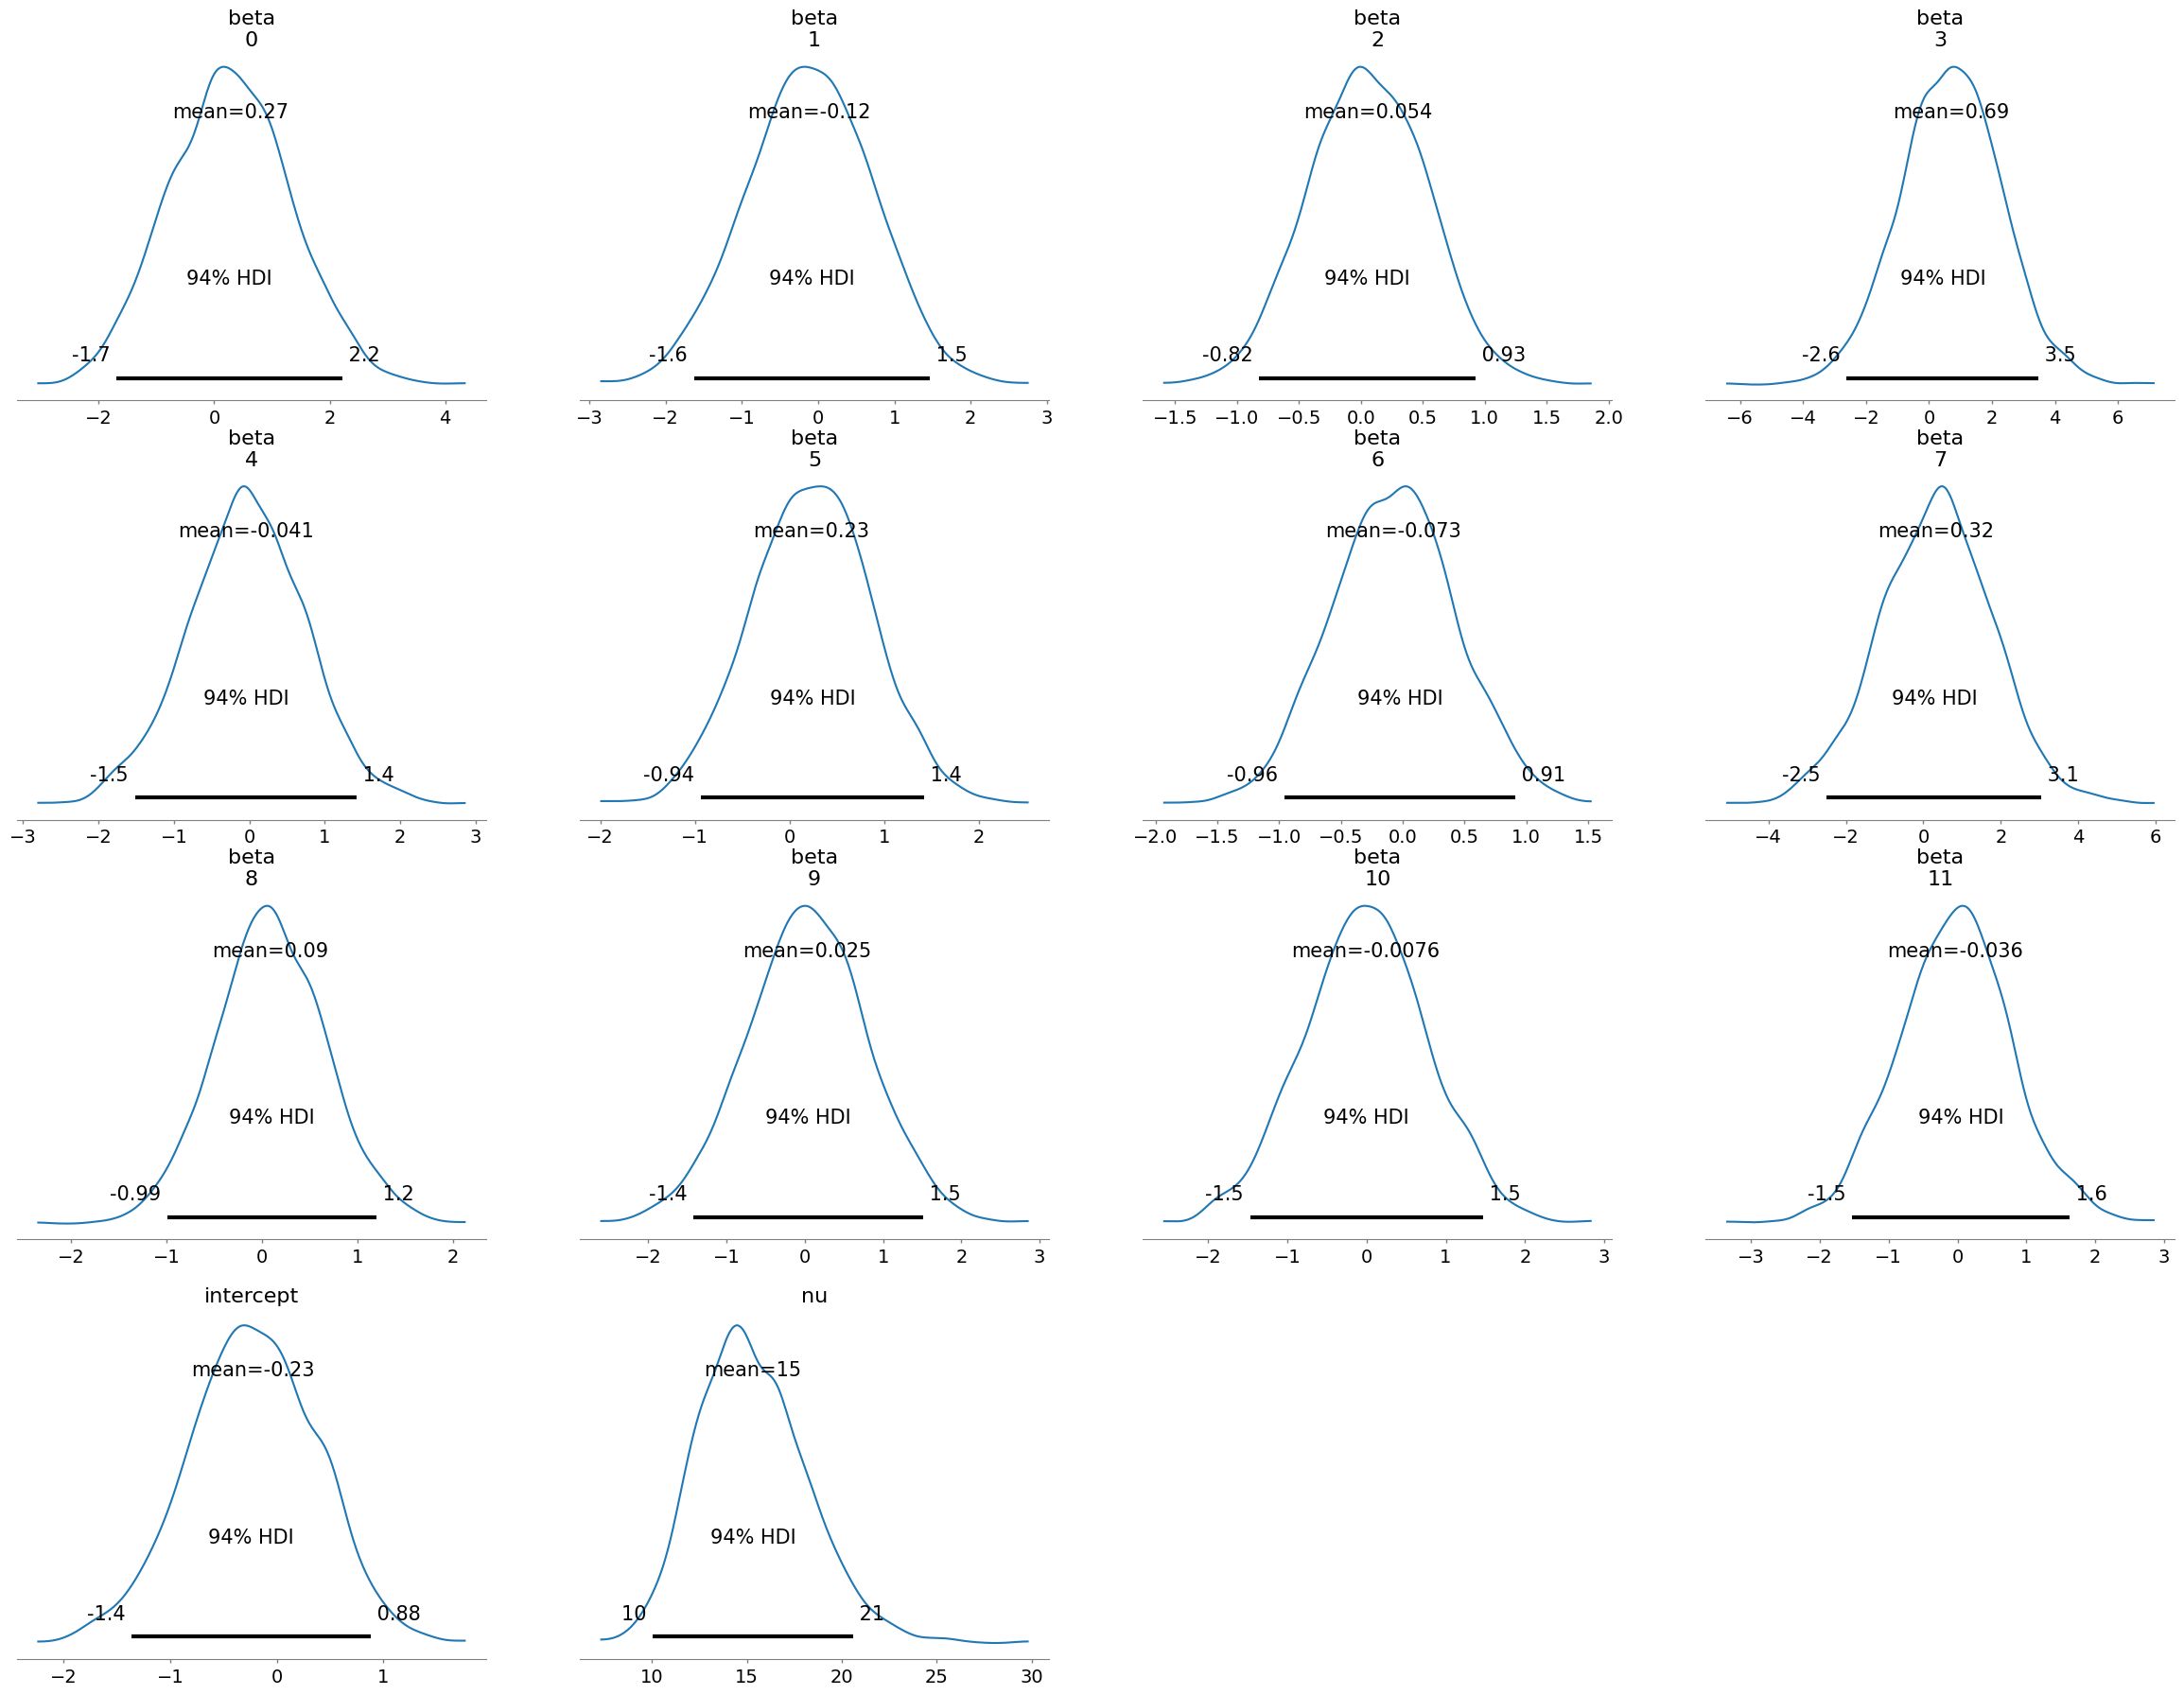

In [18]:
az.plot_posterior(student_t_summary)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


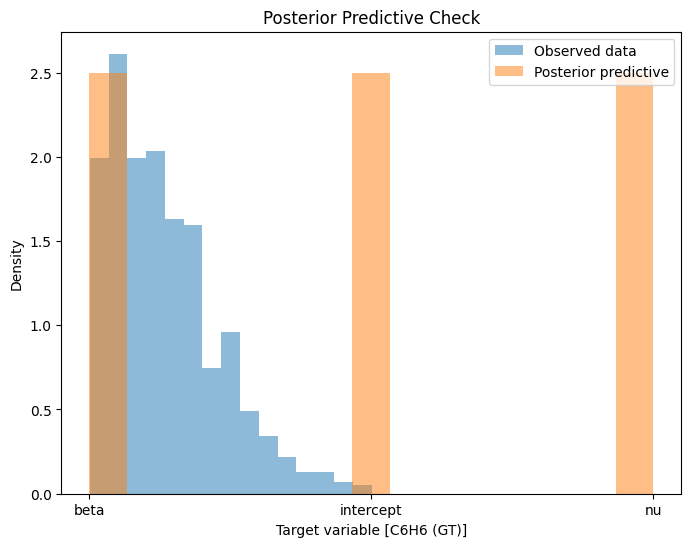

In [23]:
# trace = pm.sample(1000, tune=500, init="adapt_diag", start=initial_point)
# student_t_posterior_predictive = pm.sample_posterior_predictive(target, model=student_t_model)
# print(type(posterior_predictive))
student_t_posterior_predictive = trace_student_t
print(student_t_posterior_predictive)
# Visualize the posterior predictive checks
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(y, bins=15, density=True, alpha=0.5, label="Observed data")
ax.hist(student_t_posterior_predictive["posterior"], bins=15, density=True, alpha=0.5, label="Posterior predictive")
ax.set_xlabel("Target variable [C6H6 (GT)]")
ax.set_ylabel("Density")
ax.legend()
plt.title("Posterior Predictive Check")
plt.show()

Hierarchical model (Grouping Check)

In [26]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

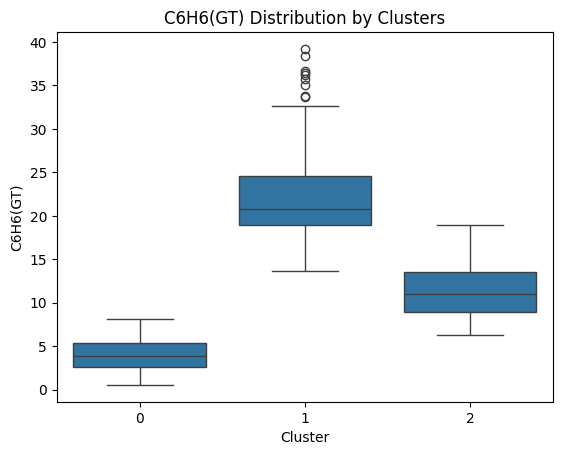

In [27]:
# Select relevant predictors for clustering (ignoring non-informative columns like 'Unnamed: 0')
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Standardize the predictor variables for clustering
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[predictor_columns])

# Apply K-Means clustering to find natural groups in the data
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters as an example
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the distribution of the target variable within the clusters
sns.boxplot(x='cluster', y='C6H6(GT)', data=data)
plt.title("C6H6(GT) Distribution by Clusters")
plt.xlabel("Cluster")
plt.ylabel("C6H6(GT)")
plt.show()

# Summary statistics for each cluster
cluster_summary = data.groupby("cluster")[predictor_columns + ['C6H6(GT)']].mean()

In [30]:
cluster_summary.head()

,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
cluster,,,,,,,,,,,,,
0,1.099363,981.406847,68.799363,698.687102,71.461783,1229.687367,70.652866,1321.282643,682.866242,12.771842,53.457511,0.763095,3.981506
1,4.513295,1551.542389,545.693642,1349.135356,264.479769,658.124277,137.797688,2050.468690,1598.689788,17.746869,48.152698,0.936480,22.175780
2,2.412941,1241.835049,220.735294,1017.883578,148.476471,872.267402,108.502941,1629.426716,1099.391667,17.119167,45.435024,0.842111,11.241603


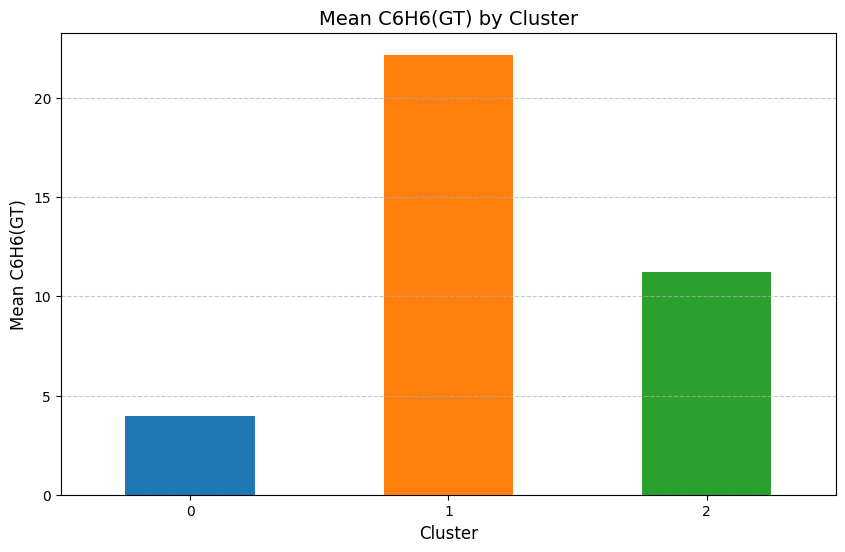

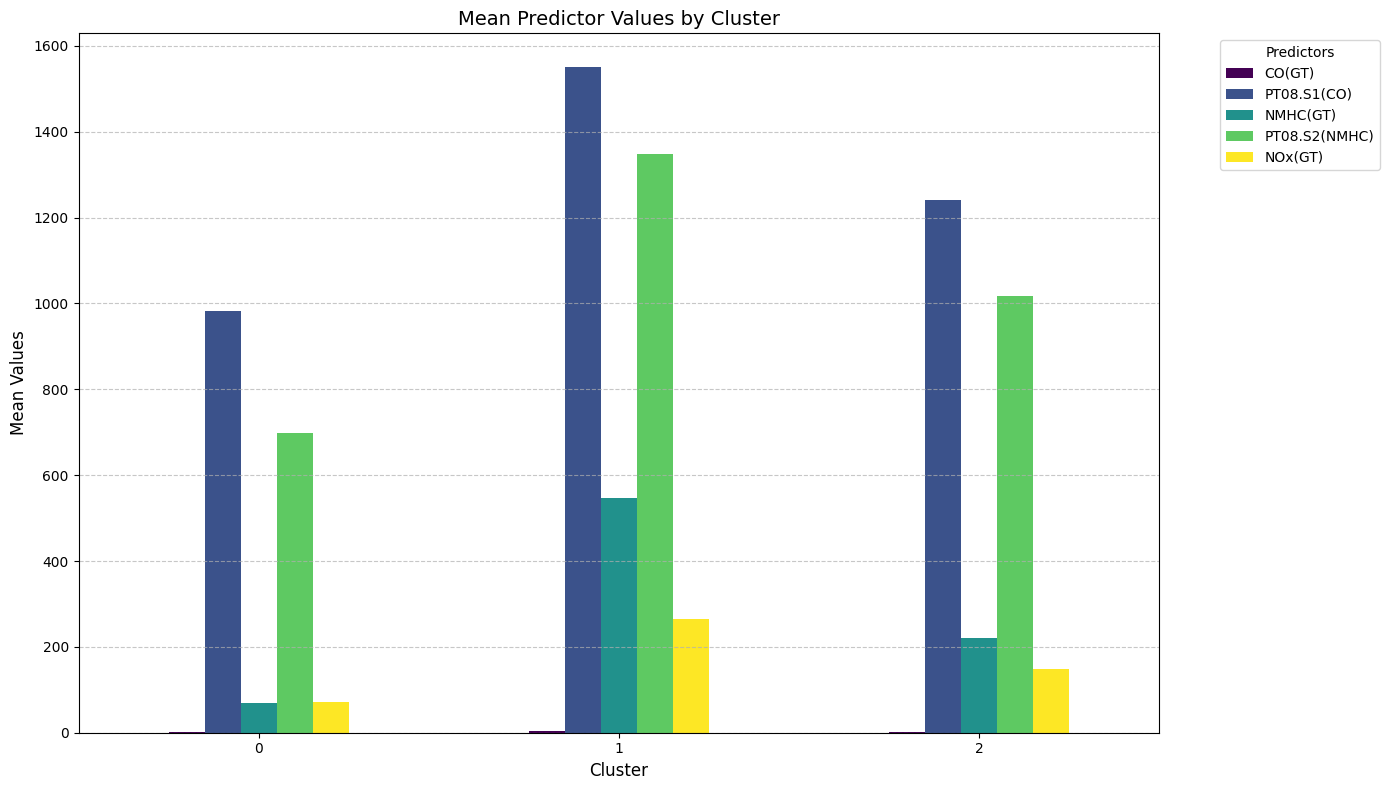

In [31]:
# Compute the mean values for each cluster
cluster_means = data.groupby("cluster")[predictor_columns + ["C6H6(GT)"]].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means["C6H6(GT)"].plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
ax.set_title("Mean C6H6(GT) by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean C6H6(GT)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.show()

# Visualize a subset of predictors by cluster
fig, ax = plt.subplots(figsize=(14, 8))
cluster_means[predictor_columns[:5]].plot(kind="bar", ax=ax, colormap="viridis")
ax.set_title("Mean Predictor Values by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean Values", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title="Predictors", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Hierarchical Modelling

In [ ]:
# Prepare data for hierarchical modeling
group_idx = data["cluster"].values  # Use clusters as the grouping variable
n_groups = len(np.unique(group_idx))  # Number of clusters/groups
X = data[predictor_columns].values  # Predictors
y = data["C6H6(GT)"].values  # Target variable

# Ensure the target variable is strictly positive
if (y <= 0).any():
    y += 0.001

# Define the hierarchical Bayesian model
with pm.Model() as hierarchical_model:
    # Hyperpriors for group-level parameters
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10, shape=len(predictor_columns))  # Population-level mean for coefficients
    sigma_beta = pm.HalfCauchy("sigma_beta", beta=2, shape=len(predictor_columns))  # Population-level variance

    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)  # Population-level mean for intercept
    sigma_intercept = pm.HalfCauchy("sigma_intercept", beta=2)  # Population-level variance

    # Group-level parameters
    intercept = pm.Normal("intercept", mu=mu_intercept, sigma=sigma_intercept, shape=n_groups)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=(n_groups, len(predictor_columns)))

    # Linear predictor for each group
    mu = pm.math.exp(intercept[group_idx] + pm.math.sum(beta[group_idx] * X, axis=1))

    # Shape parameter for Gamma likelihood
    alpha = pm.HalfCauchy("alpha", beta=2)

    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y)

    # Sample the posterior
    hierarchical_trace = pm.sample(1000, tune=500, init="adapt_diag", return_inferencedata=True)

    # Posterior predictive checks
    hierarchical_posterior_predictive = pm.sample_posterior_predictive(hierarchical_trace, model=hierarchical_model)

Linear Model (Bayesian)

In [8]:
# Define predictors and target
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
                    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = scaled_data[predictor_columns].values  # Predictors
y = scaled_data["C6H6(GT)"].values  # Target variable

# Ensure the target is strictly positive
if (y <= 0).any():
    y += 0.001

# Bayesian Linear Regression
with pm.Model() as linear_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    sigma = pm.HalfCauchy("sigma", beta=2)  # Noise standard deviation

    # Linear model
    mu = pm.math.dot(X, beta) + intercept  # Linear predictor

    # Likelihood
    target = pm.Normal("target", mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(1000, tune=500, return_inferencedata=True)

    # Posterior predictive checks
    posterior_predictive = pm.sample_posterior_predictive(trace, model=linear_model)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, sigma]


Output()

Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [target]


Output()

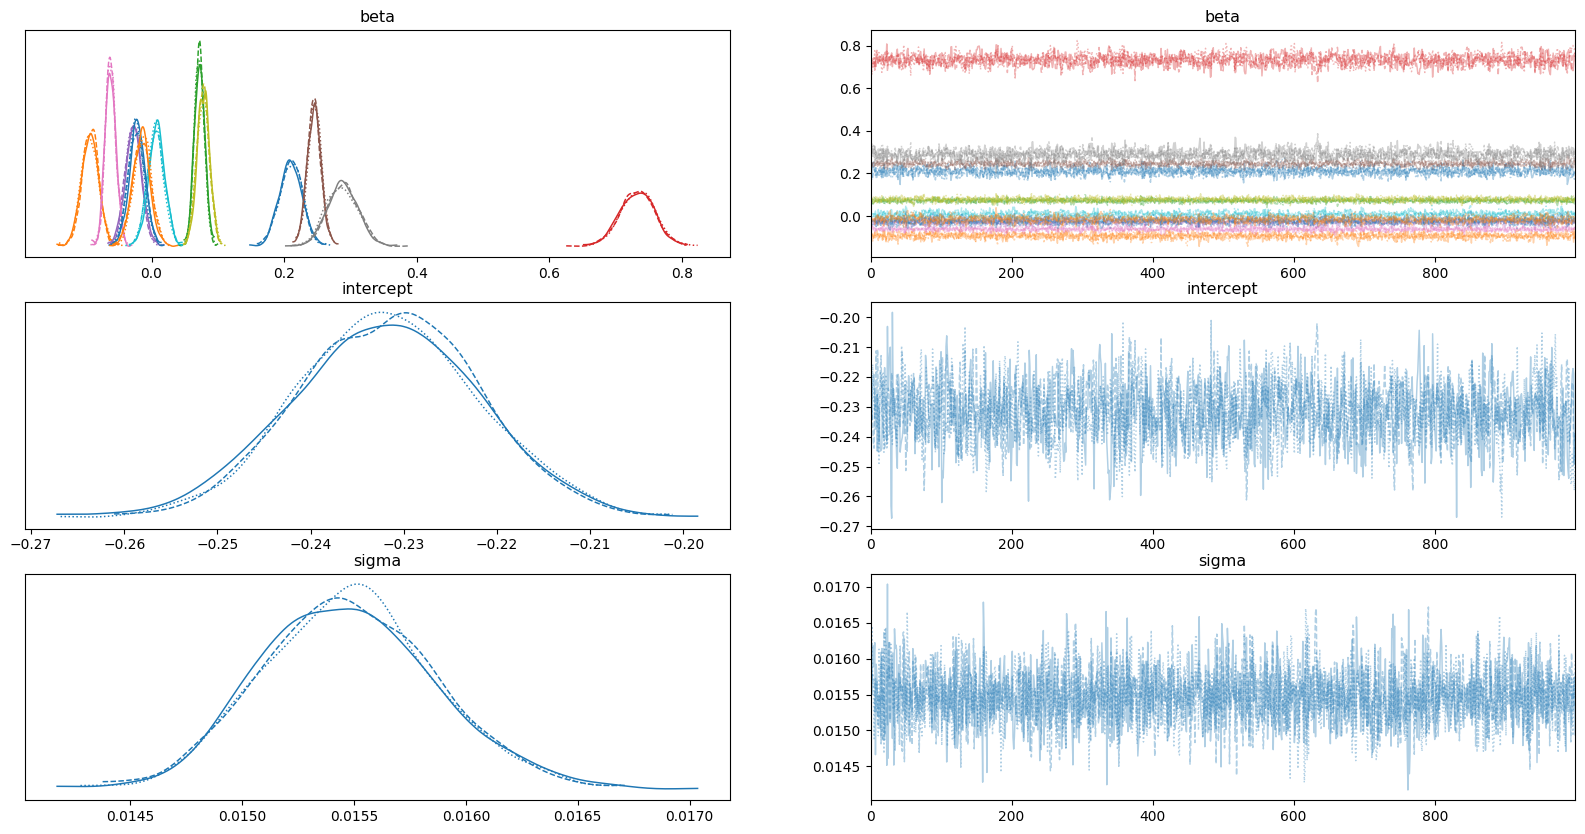

In [25]:
az.plot_trace(trace, figsize=(20, 10), compact=True)
plt.show()

In [11]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

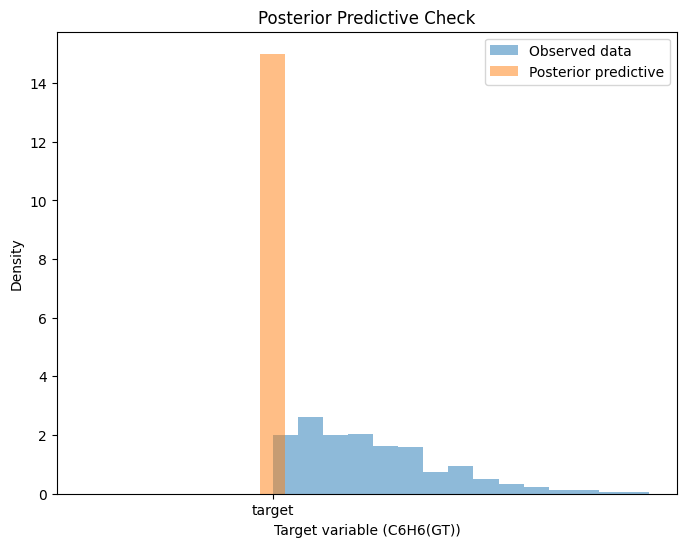

In [ ]:
# Posterior predictive check
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(y, bins=15, density=True, alpha=0.5, label="Observed data")
ax.hist(posterior_predictive["posterior_predictive"], bins=15, density=True, alpha=0.5, label="Posterior predictive")
ax.set_xlabel("Target variable (C6H6(GT))")
ax.set_ylabel("Density")
ax.legend()
plt.title("Posterior Predictive Check")
plt.show()

In [35]:
posterior_samples = posterior_predictive["posterior_predictive"]["target"].mean(dim="draw").values

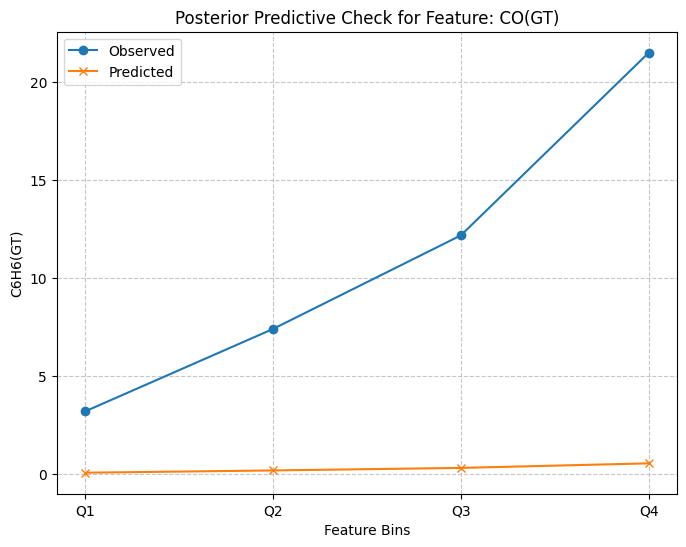

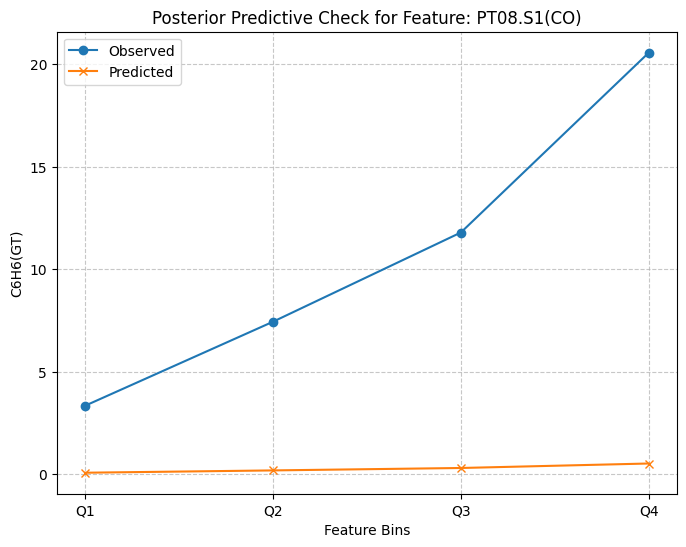

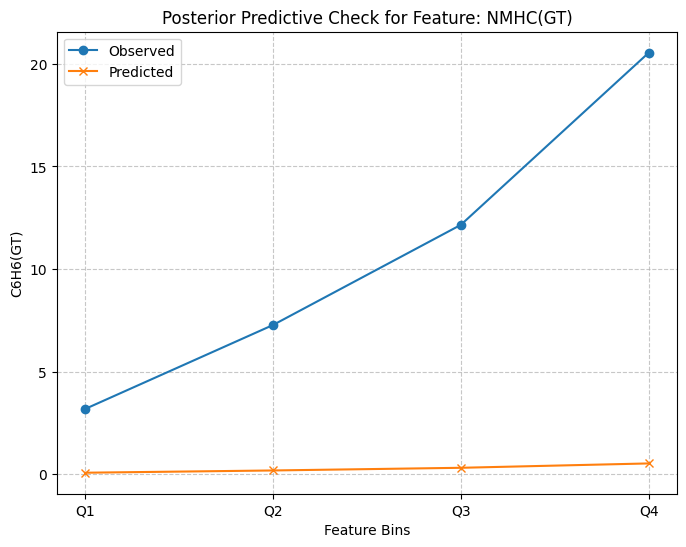

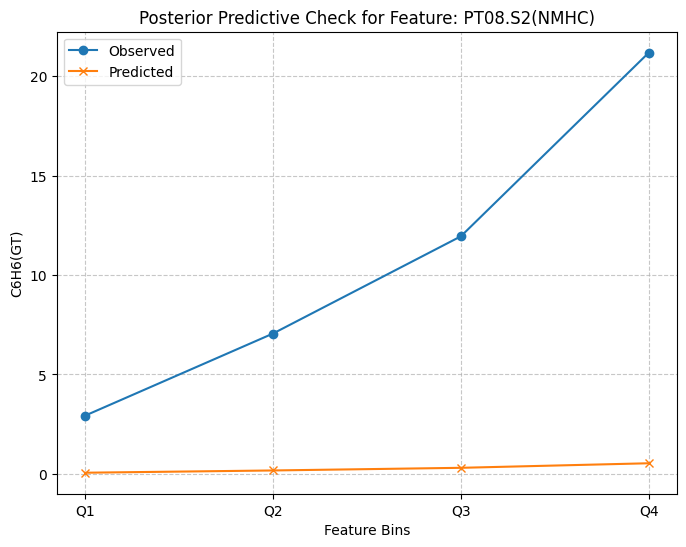

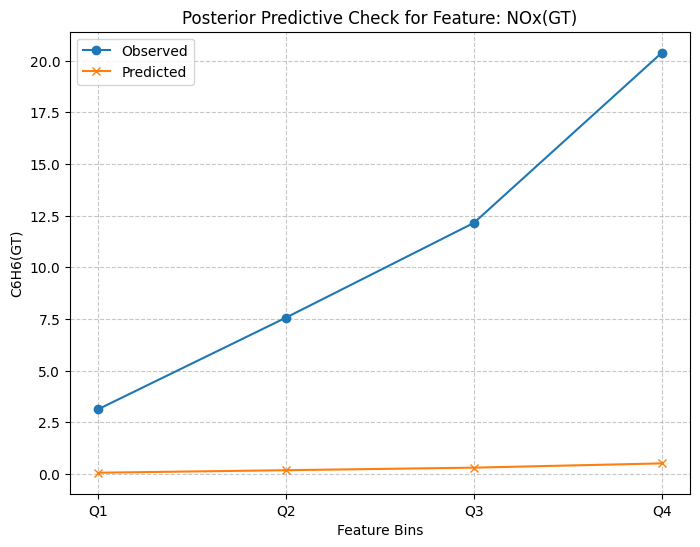

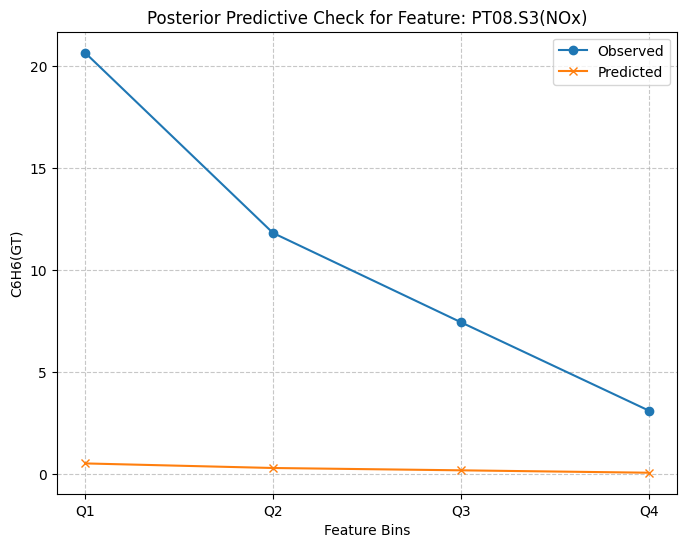

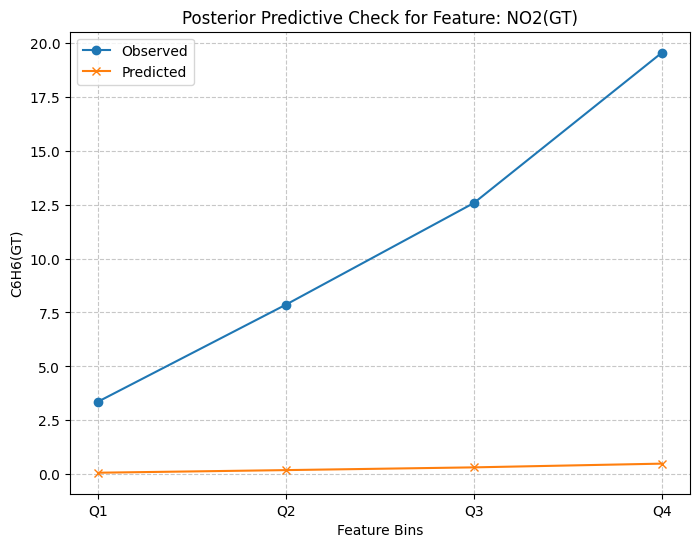

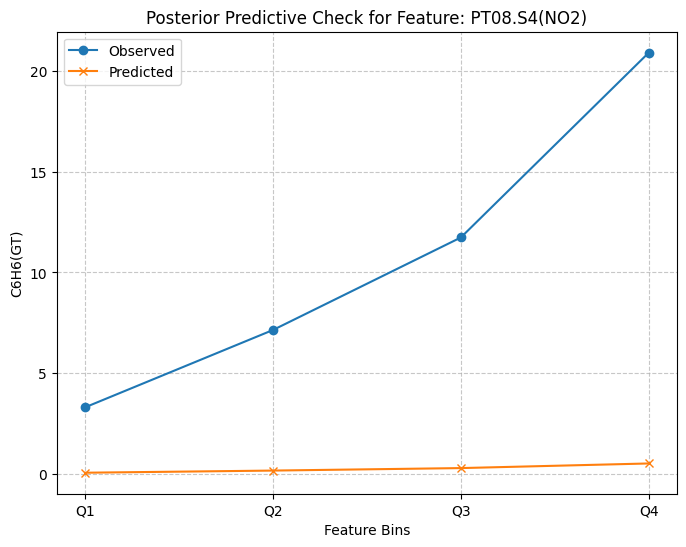

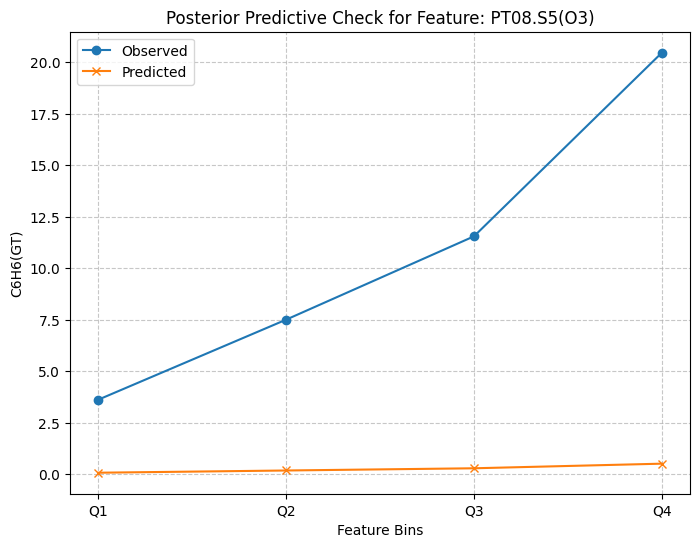

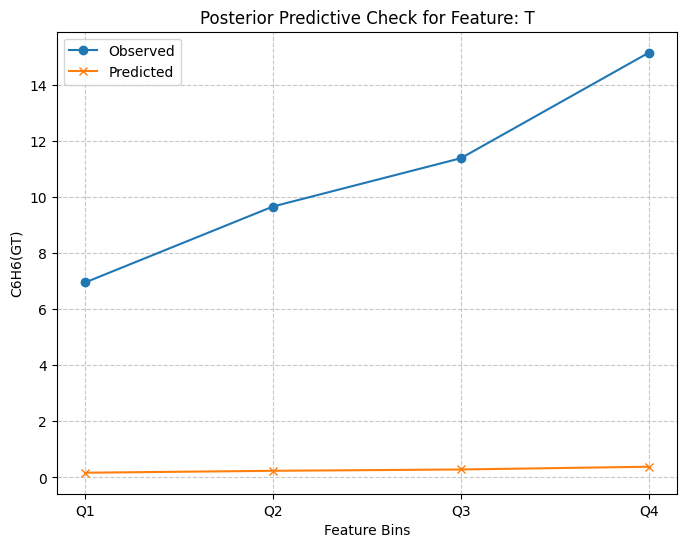

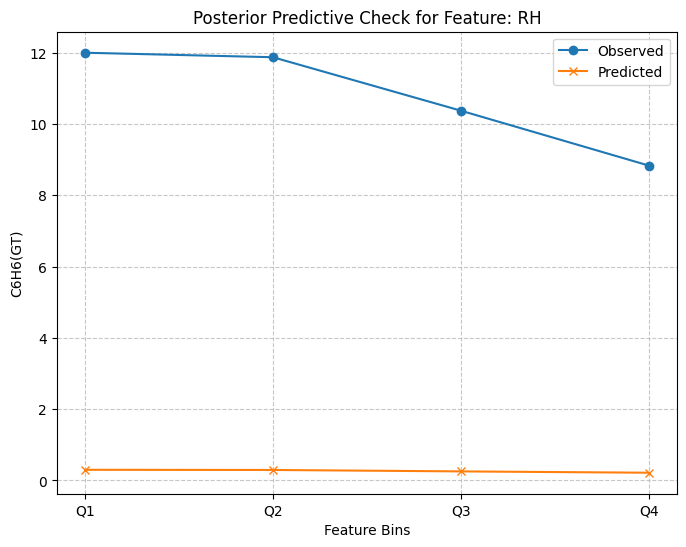

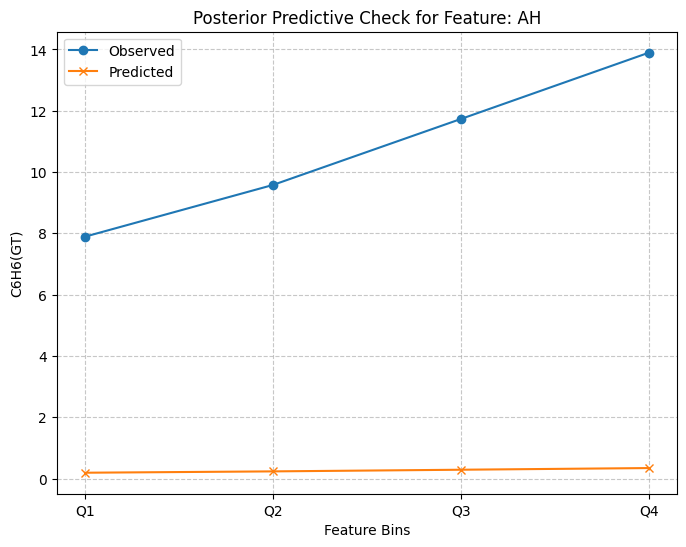

In [36]:
# Compute posterior predictive means for each observation
posterior_means = posterior_samples.mean(axis=0)  # Average over the draws

# Convert predictors to a DataFrame
X_scaled_df = pd.DataFrame(X, columns=predictor_columns)

# Iterate through each predictor
for feature in predictor_columns:
    # Bin the feature into quantiles for grouping
    bins = np.quantile(X_scaled_df[feature], [0, 0.25, 0.5, 0.75, 1.0])  # Quartiles
    bin_labels = ['Q1', 'Q2', 'Q3', 'Q4']
    X_scaled_df[f"{feature}_bin"] = pd.cut(X_scaled_df[feature], bins=bins, labels=bin_labels, include_lowest=True)

    # Compute observed and predicted means for each bin
    observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
    predicted_means = pd.DataFrame({
        f"{feature}_bin": X_scaled_df[f"{feature}_bin"],
        "predicted": posterior_means
    }).groupby(f"{feature}_bin")["predicted"].mean()

    # Plot observed vs. predicted for the feature
    plt.figure(figsize=(8, 6))
    plt.plot(bin_labels, observed_means, label="Observed", marker="o")
    plt.plot(bin_labels, predicted_means, label="Predicted", marker="x")
    plt.title(f"Posterior Predictive Check for Feature: {feature}")
    plt.xlabel("Feature Bins")
    plt.ylabel("C6H6(GT)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
